In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
%%HTML
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>

In [3]:
#Import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sci
%matplotlib inline

In [4]:
#Import and investigate dataset
df = pd.read_csv ('Voodoo_Test_Business_Case.csv',sep=';')
#display(df.head())

In [5]:
#Create total game count field
df['total_game_count'] = df['game_count'] + df['offline_game_count']

#Create session level datasets
df_session_level = df.loc[:,['platform','session_id','open_at','user_id','session_length','session_number_','publisher_revenue','fs_shown','game_count','offline_game_count','total_game_count','ab_cohort_name']]

#Convert to categorical to get more sensible ordering in the tables below
df_session_level['ab_cohort_name'] = pd.Categorical(df_session_level['ab_cohort_name'], ['control', 'gameTune', 'xxLow','xLow','xHigh','xxHigh'])

#df_session_level.head()

In [6]:
#Create user level datasets
df_user_level = df.loc[:,['ab_cohort_name','platform','user_id','session_length','session_number_','publisher_revenue','fs_shown','game_count','offline_game_count','total_game_count']]

#Convert to categorical to get more sensible ordering in the tables below
df_user_level['ab_cohort_name'] = pd.Categorical(df_user_level['ab_cohort_name'], ['control', 'gameTune', 'xxLow','xLow','xHigh','xxHigh'])

df_user_level = df.groupby(['ab_cohort_name','platform','user_id']).agg({'session_length':'sum',
                                           'session_number_':'max',
                                           'publisher_revenue':'sum',
                                           'fs_shown':'sum',
                                           'game_count':'sum',
                                           'offline_game_count':'sum',
                                           'total_game_count':'sum'}).reset_index()

#df_user_level.head()

## Introduction

In this AB test we are investigating the impact of differing interstitial advertising frequencies on new users. We are looking at the amount of revenue earnt from ads as well as any impact on the amount of time spent by users in the game.

To measure this we will be looking various metrics:
- The amount of revenue earnt from adverts
- The number of adverts seen by users
- The total length of time spent in the game
- The total number of games played

This will allow us to measure the impact of the different ad frequencies whilst ensuring that the number of ads shown doesn't negatively impact the player experience.

We have collected data from new users in the game Ball Mayhem on both Android and iOS platforms. As there appears to be material differences between the two platforms, they are considered independently here. Data is collected from 04/02/2020 to 17/02/2020.

## Executive Summary

The test has shown the expected result. 

As the frequency of ads interstitial ads is increased there is an increase in the number of ads seen and the revenue received from advertising. Additionally there is a reduction in the total game sessions and the total session length. This indicates that users are playing the games slightly less, but are seeing more ads in the time they spent in game.

On iOS the xxHigh variant earnt £0.251 per user compared to £0.199 per user in the xxLow variant. The total number of game sessions falling from 14.4 per user in the xxLow variant to 10.7 per user in the xxHigh variant.  
These results are broadly statistically significant at the 5% level and are unlikely to be due to random fluctuations(see below for more details).

There also appears to be a postitive correlation between the number of ads shown and the advertising revenue. ie: The more ads shown the more revenue received.  
None of the variants appear to be aggressive enough to reduce the level of advertising revenue by scaring away users.

There is no clear variant which outperforms all others. Instead there is a tradeoff between advertising revenue and gameplay metrics. The variants with higher revenue metrics have lower gameplay metrics and vice versa. The 'best' variant is dependant on how the business values gameplay and revenue.

My recommendation would be to roll out one of the variants with a higher advertising frequency if the expected reduction in game sessions is within acceptable ranges of loss for the business.  
However there appears to be a difference in implementation between iOS and Android. This should be investigated before the test is rolled out.

## User Level Metrics

First let us take a look at the user level metrics. Here we are showing the average values at a user level (eg: The average amount of revenue earnt for each user). The distributions show the proportion of users with a given level of activity.

We can see that the results are roughly what we would expect. There are a higher number of adverts watched in the variants which have a higher ad frequency and a high amount of revenue per user in those variants. The xxHigh variant is earning £0.251 per user on iOS compared to the £0.239 per user in the control group on iOS.  
Additionally the number of total games is down from 13.73 in the control group to 13.03 in the xxHigh group on the same platform.

Looking at the distributions for these metrics we can see a difference between the two platforms.   
There is a clear relationship between the number of ads shown and the metrics on iOS. As the frequency of adverts increases, the distribution for publisher revenue shifts to the right (indicating an increase in overall revenue). This is not the case for Android where there appear to be 2 'clumps', xLow/xxLow and the other variant groups. This can also be seen in the distribution for the numbers of ads shown. This may indicate that the implementation or impact of the different ad frequencies is not consistent between platforms. This should be investigated before moving forward with any recommendations.

NOTE: The distribution graphs have the top 5% of users removed in order to make the graphs more legible by removing the long tail. These users are not removed from the aggregate tables.

In [7]:
#user level table
#Create top level metrics. Gives an overview of what is in the data and what may need investigation and testing

# Ideally we would look at D1/W1 retention. However constructing that metric from this dataset appeared to be time consuming

table_df = df_user_level.groupby(['platform','ab_cohort_name']).mean().reset_index()
table_df.columns = ['Platform','Variant Name','Total Session Length','Highest Session Number','Revenue','FS Shown','Game Count','Offline Game Count','Total Game Count']

table_df['Variant Name'] = pd.Categorical(table_df['Variant Name'], ['control', 'gameTune', 'xxLow','xLow','xHigh','xxHigh'])

table_df = table_df.sort_values(['Platform','Variant Name'])

table_df =  table_df.style.format({'Total Session Length':'{:.2f}',
                                   'Highest Session Number':'{:.2f}',
                                   'Revenue':'£{:.3f}',
                                   'FS Shown':'{:.2f}',
                                   'Game Count':'{:.2f}',
                                   'Offline Game Count':'{:.2f}',
                                   'Total Game Count':'{:.2f}'
                                  }).hide_index()

display(table_df)

Platform,Variant Name,Total Session Length,Highest Session Number,Revenue,FS Shown,Game Count,Offline Game Count,Total Game Count
android,control,1264.41,3.46,£0.103,13.96,12.09,1.64,13.73
android,gameTune,1205.46,3.34,£0.103,14.10,11.42,1.45,12.88
android,xxLow,1275.88,3.39,£0.092,11.72,12.53,1.43,13.96
android,xLow,1283.66,3.41,£0.095,12.44,12.37,1.45,13.82
android,xHigh,1224.81,3.38,£0.105,14.21,11.46,1.51,12.97
android,xxHigh,1226.18,3.42,£0.108,14.88,11.54,1.49,13.03
ios,control,1297.64,4.53,£0.239,17.48,12.85,0.49,13.34
ios,gameTune,1216.20,4.37,£0.242,18.05,11.52,0.54,12.06
ios,xxLow,1368.37,4.49,£0.199,13.52,14.12,0.30,14.42
ios,xLow,1309.00,4.44,£0.207,13.97,13.52,0.42,13.95


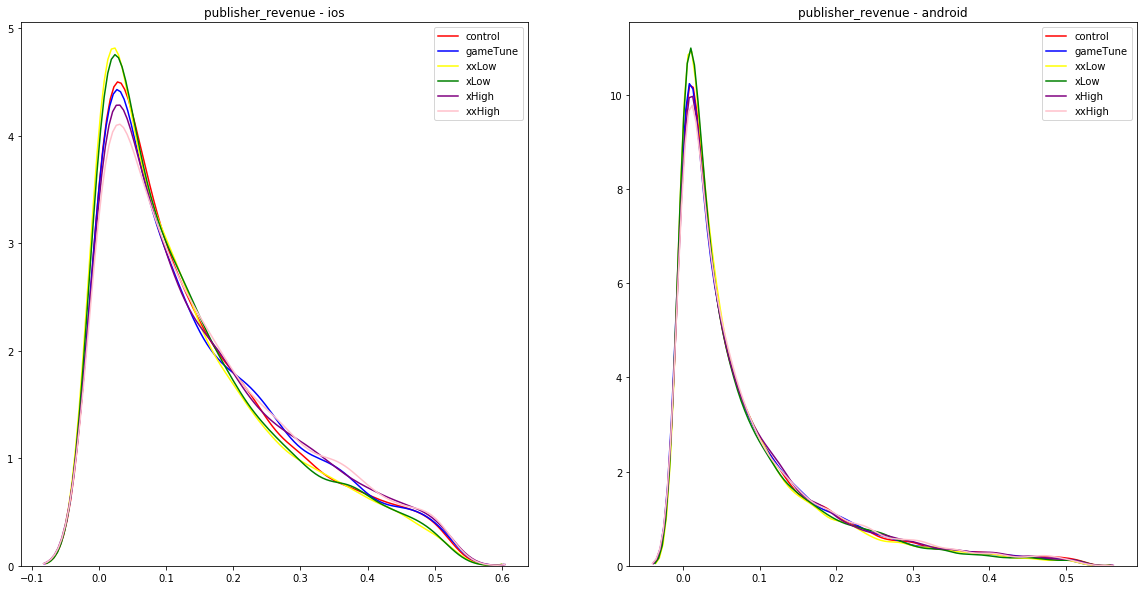

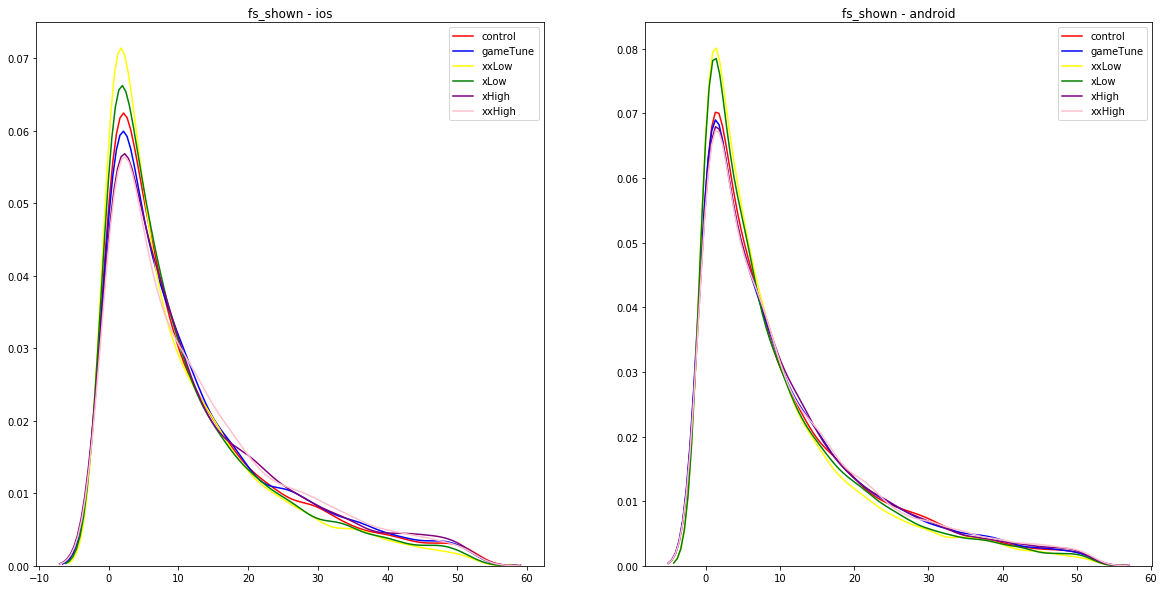

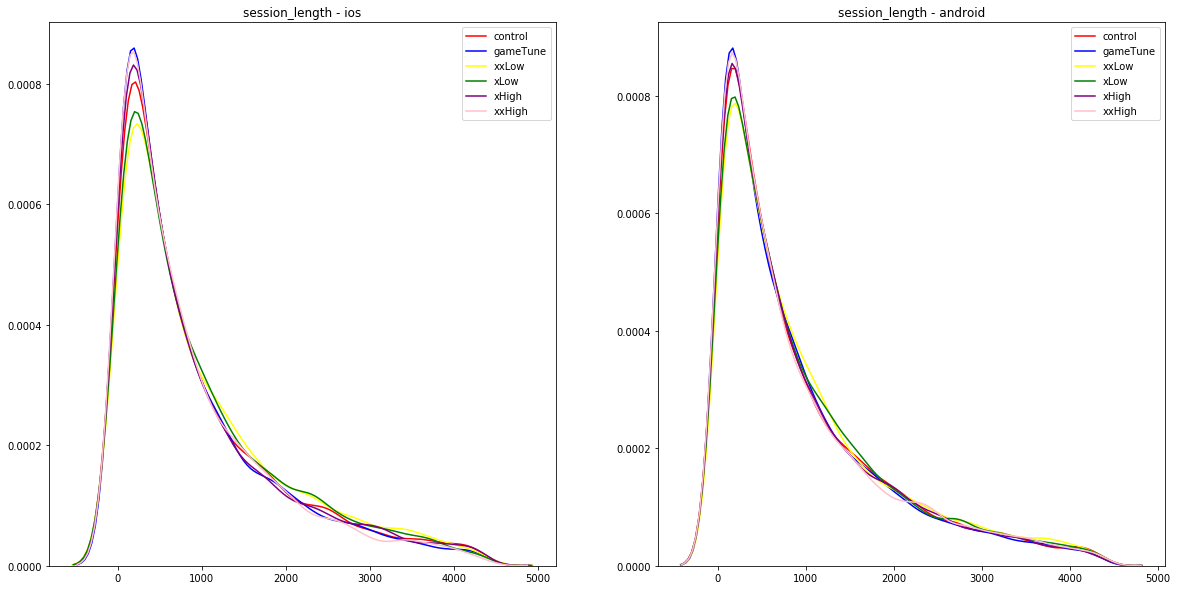

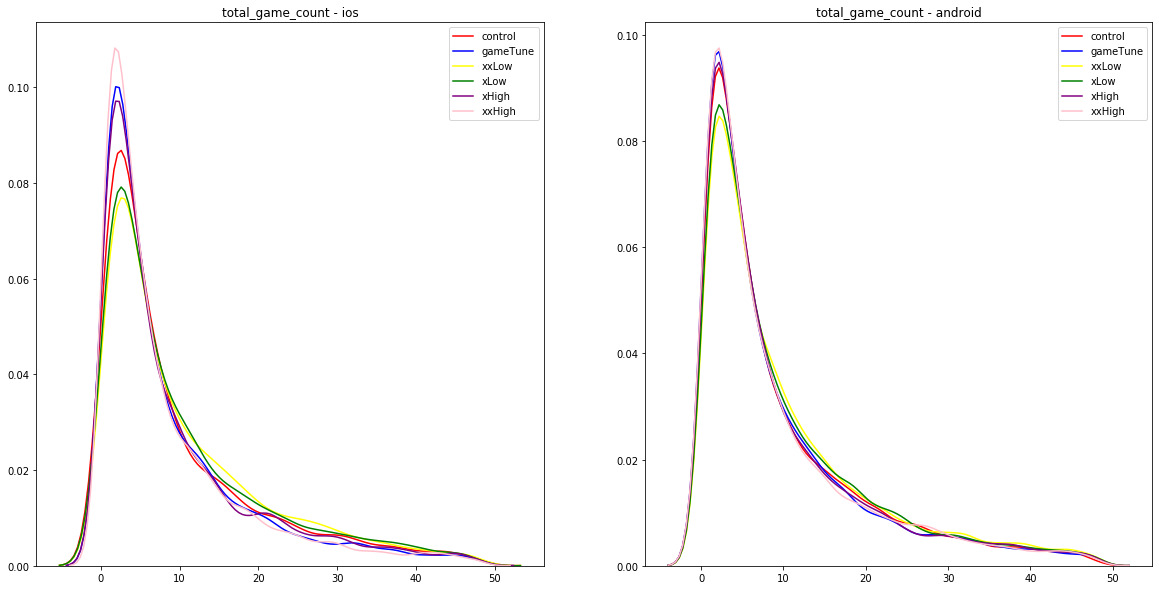

In [8]:
# user level metric distributions
# This could be funcitonised, but not necessary
# Explore primary metrics here. Take a look at the distributions to see what the top level results are to motivate further investigation.
# Initially do not use the 95 percentile filter. Look for outliers and other inconsistencies in the data
# Colour pallette isn't great. Consider changing to brand colours or more readable colours, omitted due to time

# Differences in the top level aggregations including/excluding the top 5% should be investigated. 
# This would allow us to see if the differences in the average are primarly driven by the heaviest users or is more spread out amongst the whole user base


colour_list = ['red','blue','yellow','green','purple','pink']
cohort_list = ['control','gameTune','xxLow','xLow','xHigh','xxHigh']
platform_list = ['ios','android']
metric_list =  ['publisher_revenue', 'fs_shown', 'session_length', 'total_game_count']


for metric in metric_list:
    plot_df = df_user_level.loc[(df_user_level[metric]<=df_user_level[metric].quantile(.95))
                                ,['ab_cohort_name','platform',metric]]

    fig, axes = plt.subplots(1,2,figsize=(20,10))
    
    for j,platform in enumerate(platform_list):

        for i,cohort in enumerate(cohort_list):
            plot_colour = colour_list[i]

            sns.kdeplot(plot_df.loc[(plot_df['ab_cohort_name']==cohort) &
                                    (plot_df['platform']==platform),
                                    metric],
                        cumulative=False,
                        color=plot_colour,
                        label = '{}'.format(cohort),
                        ax = axes[j]).set_title('{} - {}'.format(metric,platform))
    plt.show()
    
    

## Session Level Metrics

Here we are showing the average values at a user level (eg: The average amount of revenue earnt per game session). The distributions show the proportion of game session with a given level of activity.

The session level metrics show a similar story. Ad related metrics are higher in variants with a higher ad frequency and time spent in the game is lower, as is expected.

We can also see the same difference between the platforms in the number of adverts seen. On iOS there appears to be a more even change in the number of adverts seen between the variants whereas on Android there appears to be two groupings. This indicates that any implementation difference may be on a session not user level.

NOTE: The distribution graphs have the top 5% of users removed in order to make the graphs more legible by removing the long tail. These users are not removed from the aggregate tables.

In [9]:
#Session level table
table_df = df_session_level.loc[:,['platform','session_length','publisher_revenue','fs_shown','total_game_count','game_count','offline_game_count','ab_cohort_name']].copy()
table_df = table_df.groupby(['platform','ab_cohort_name']).mean()

table_df = table_df.reset_index().sort_values(['platform','ab_cohort_name'])

table_df.columns = ['Platform','Variant Name','Total Session Length','Revenue','FS Shown','Total Game Count','Game Count','Offline Game Count']

table_df =  table_df.style.format({'Total Session Length':'{:.2f}',
                                   'Revenue':'£{:.3f}',
                                   'FS Shown':'{0:,.2f}',
                                   'Game Count':'{:.2f}',
                                   'Offline Game Count':'{:.2f}',
                                   'Total Game Count':'{:.2f}'
                                  }).hide_index()

display(table_df)


Platform,Variant Name,Total Session Length,Revenue,FS Shown,Total Game Count,Game Count,Offline Game Count
android,control,367.63,£0.030,4.06,3.99,3.51,0.48
android,gameTune,363.59,£0.031,4.25,3.88,3.45,0.44
android,xxLow,378.60,£0.027,3.48,4.14,3.72,0.42
android,xLow,379.16,£0.028,3.67,4.08,3.65,0.43
android,xHigh,364.71,£0.031,4.23,3.86,3.41,0.45
android,xxHigh,361.17,£0.032,4.38,3.84,3.40,0.44
ios,control,291.08,£0.054,3.92,2.99,2.88,0.11
ios,gameTune,282.07,£0.056,4.19,2.80,2.67,0.13
ios,xxLow,308.58,£0.045,3.05,3.25,3.18,0.07
ios,xLow,298.96,£0.047,3.19,3.19,3.09,0.10


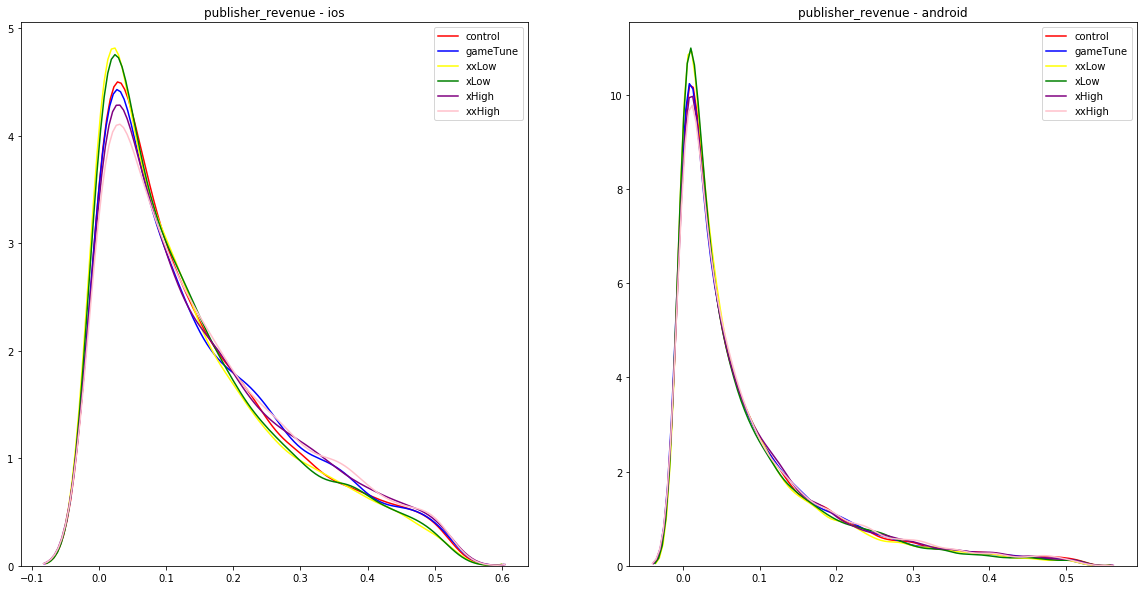

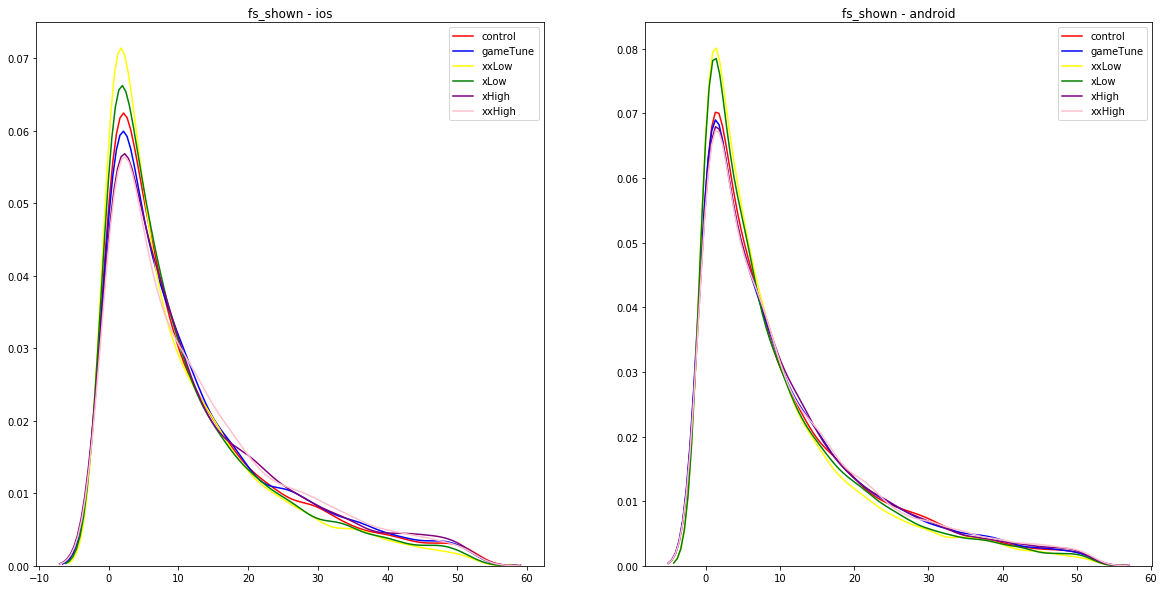

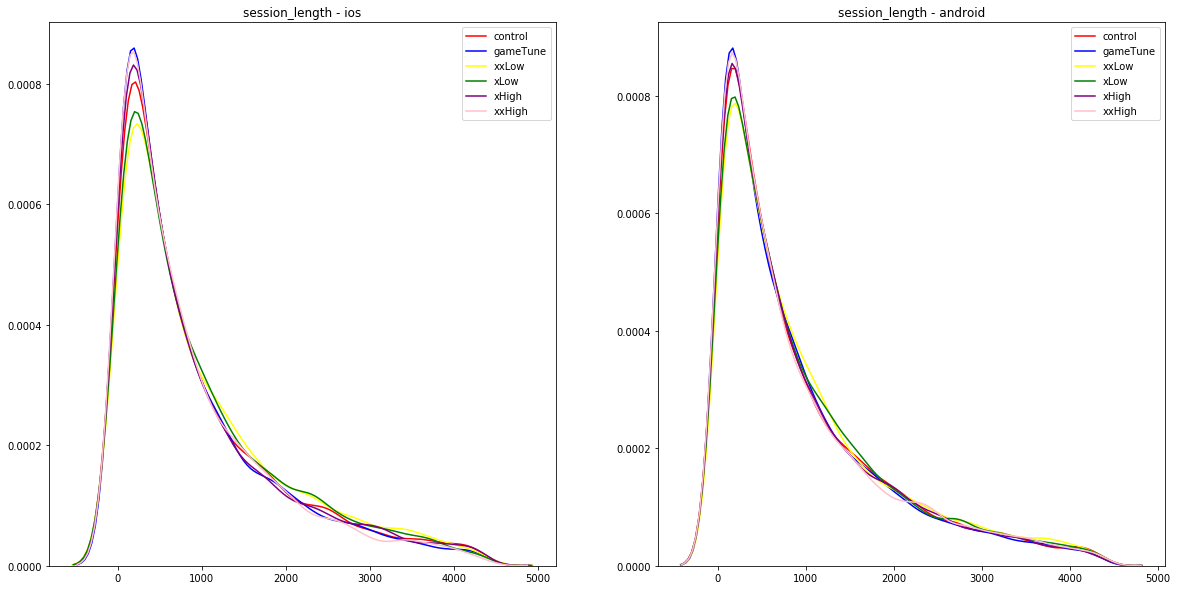

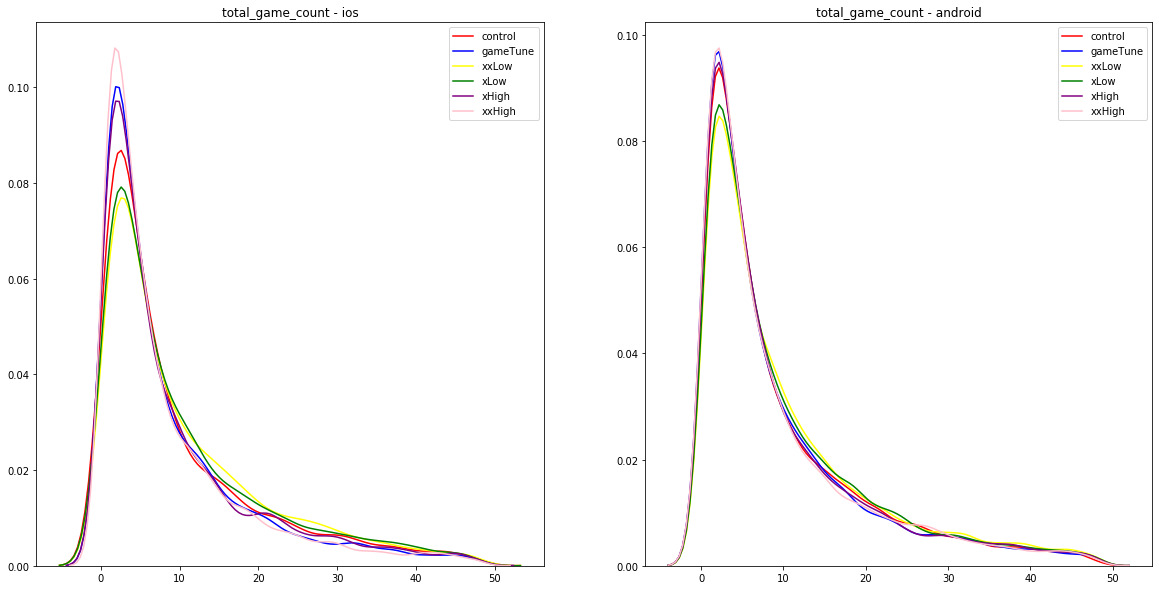

In [10]:
#Session level metric distribution

colour_list = ['red','blue','yellow','green','purple','pink']
cohort_list = ['control','gameTune','xxLow','xLow','xHigh','xxHigh']
platform_list = ['ios','android']
metric_list =  ['publisher_revenue', 'fs_shown', 'session_length', 'total_game_count']

for metric in metric_list:
    plot_df = df_user_level.loc[(df_user_level[metric]<=df_user_level[metric].quantile(.95))
                                ,['ab_cohort_name','platform',metric]]

    fig, axes = plt.subplots(1,2,figsize=(20,10))

    for i,cohort in enumerate(cohort_list):
        for j,platform in enumerate(platform_list):

            plot_colour = colour_list[i]

            sns.kdeplot(plot_df.loc[(plot_df['ab_cohort_name']==cohort) &
                                    (plot_df['platform']==platform),
                                    metric],
                        cumulative=False,
                        color=plot_colour,
                        label = '{}'.format(cohort),
                        ax = axes[j]).set_title('{} - {}'.format(metric,platform))
    plt.show()

## AB Testing of Chosen Metrics

Here we check that the differences we are seeing in the user level metrics above are statistically significant. 

In this section we are only comparing the variants against the control group.

For this test we are using the Mann Whitney U test. This tests is slightly more robust against long tailed distributions which are common for metrics from free applications. There are lots of users who play the game a small amount and a small number who may have very high game usage. Since these users contribute a lot to revenue we do not want to remove them from the testing set.

The results for the tests are fairly similar across the metrics and platforms. Almost all the comparisons against the control group are statistically significant apart from for the Control vs xHigh comparisons. Therefore the results seen above can be considered 'real' and not due to random fluctuations.

Note: As not all comparisons have been checked and the multiple comparison problem has not been accounted for, take these results with a pinch of salt. I would not recommend rolling out a variant until a more rigorous analysis of these statisitical test results has been conducted.

In [11]:
# AB testing of chosen metrics
# Very rough testing function and output.
# To add: Multiple comparison considerations, missing comparisons (ie: xLow vs xxLow), more readable output
# Check other tests and suitability of dataset for MWU test

float_formatter = "{:.3f}".format


def MWU_test(metric,platform):
    print('MWU Tests for {} on {}'.format(metric,platform))
    summary_df = pd.DataFrame()

    for variant_name in ['gameTune','xxLow','xLow','xHigh','xxHigh']:

        control = df_user_level.loc[(df_user_level['platform']==platform) &
                                    (df_user_level['ab_cohort_name']=='control'), metric]
        variant = df_user_level.loc[(df_user_level['platform']==platform) &
                                    (df_user_level['ab_cohort_name']==variant_name), metric]

        control_mean = round(df_user_level.loc[(df_user_level['platform']==platform) &
                                    (df_user_level['ab_cohort_name']=='control'), metric].mean(),3)
        
        variant_mean = round(df_user_level.loc[(df_user_level['platform']==platform) & (df_user_level['ab_cohort_name']==variant_name), metric].mean(),3)

        
        p = float_formatter(sci.stats.mannwhitneyu(control, variant)[1])

        output_d = {'Variant 1':['Control'], 'Variant 2':[variant_name],'Variant 1 Mean':[control_mean],'Variant 2 Mean':[variant_mean], 'P':[p]}
        output_df = pd.DataFrame(data=output_d, columns = ['Variant 1','Variant 2','Variant 1 Mean','Variant 2 Mean','P']) 

        summary_df = summary_df.append(output_df)

    return(summary_df)    

display(MWU_test('publisher_revenue','ios'))
display(MWU_test('fs_shown','ios'))
display(MWU_test('session_length','ios'))
display(MWU_test('total_game_count','ios'))


display(MWU_test('publisher_revenue','android'))
display(MWU_test('fs_shown','android'))
display(MWU_test('session_length','android'))
display(MWU_test('total_game_count','android'))


MWU Tests for publisher_revenue on ios


,Variant 1,Variant 2,Variant 1 Mean,Variant 2 Mean,P
0,Control,gameTune,0.239,0.242,0.213
0,Control,xxLow,0.239,0.199,0.000
0,Control,xLow,0.239,0.207,0.000
0,Control,xHigh,0.239,0.255,0.008
0,Control,xxHigh,0.239,0.251,0.003


MWU Tests for fs_shown on ios


,Variant 1,Variant 2,Variant 1 Mean,Variant 2 Mean,P
0,Control,gameTune,17.478,18.047,0.071
0,Control,xxLow,17.478,13.520,0.000
0,Control,xLow,17.478,13.968,0.000
0,Control,xHigh,17.478,18.947,0.001
0,Control,xxHigh,17.478,19.065,0.000


MWU Tests for session_length on ios


,Variant 1,Variant 2,Variant 1 Mean,Variant 2 Mean,P
0,Control,gameTune,1297.635,1216.197,0.010
0,Control,xxLow,1297.635,1368.368,0.000
0,Control,xLow,1297.635,1308.996,0.021
0,Control,xHigh,1297.635,1247.943,0.104
0,Control,xxHigh,1297.635,1147.601,0.000


MWU Tests for total_game_count on ios


,Variant 1,Variant 2,Variant 1 Mean,Variant 2 Mean,P
0,Control,gameTune,13.339,12.064,0.000
0,Control,xxLow,13.339,14.419,0.000
0,Control,xLow,13.339,13.946,0.000
0,Control,xHigh,13.339,12.129,0.001
0,Control,xxHigh,13.339,10.696,0.000


MWU Tests for publisher_revenue on android


,Variant 1,Variant 2,Variant 1 Mean,Variant 2 Mean,P
0,Control,gameTune,0.103,0.103,0.372
0,Control,xxLow,0.103,0.092,0.000
0,Control,xLow,0.103,0.095,0.000
0,Control,xHigh,0.103,0.105,0.110
0,Control,xxHigh,0.103,0.108,0.018


MWU Tests for fs_shown on android


,Variant 1,Variant 2,Variant 1 Mean,Variant 2 Mean,P
0,Control,gameTune,13.963,14.098,0.316
0,Control,xxLow,13.963,11.715,0.000
0,Control,xLow,13.963,12.435,0.000
0,Control,xHigh,13.963,14.207,0.029
0,Control,xxHigh,13.963,14.882,0.000


MWU Tests for session_length on android


,Variant 1,Variant 2,Variant 1 Mean,Variant 2 Mean,P
0,Control,gameTune,1264.405,1205.463,0.010
0,Control,xxLow,1264.405,1275.883,0.000
0,Control,xLow,1264.405,1283.662,0.002
0,Control,xHigh,1264.405,1224.810,0.147
0,Control,xxHigh,1264.405,1226.180,0.023


MWU Tests for total_game_count on android


,Variant 1,Variant 2,Variant 1 Mean,Variant 2 Mean,P
0,Control,gameTune,13.73,12.876,0.000
0,Control,xxLow,13.73,13.957,0.000
0,Control,xLow,13.73,13.815,0.000
0,Control,xHigh,13.73,12.966,0.010
0,Control,xxHigh,13.73,13.026,0.000


## Next steps

Initially I would advise that the potential implementation differences between iOS and Android be investigated. 

Country level splits may also inform us of differing appetites for adverts in different countries, allowing for a advertising strategy which is catering on a per country or per region basis.

Using smaller scale tests try to find the point at which more adverts generates lower revenue by scaring away users. This would allow the business to know the 'ceiling' in terms of the number of adverts that can be shown to users.